In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH21-AGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-AGENT


# Tool Calling Agent 

- 도구 호출 : LLM 모델이 하나 이상의 도구가 호출되어야 하는 시기를 감지하고, 해당 도구에 전달해야 하는 입력값 전달 
- API 호출 : 도구를 설명하고 모델이 도구를 호출하기 위한 인수가 포함된 JSON과 같은 구조화된 객체를 출력 

- 도구 API : 일반 텍스트 완성이나 채팅 API를 사용하여 수행하는 것 보다 **더 안정적이고 유효하고 유용한 도구 호출**을 반환하는 것이 목표 
- Agent : 도구 API 호출 통해 사용자 요청을 해결할 때까지 반복적으로 도구를 호출하고 결과를 수신하는 역할 
 
- [Ref] https://python.langchain.com/v0.1/docs/modules/agents/agent_types/tool_calling/

In [4]:
from langchain.agents import tool
from typing import List, Dict, Annotated
from langchain_teddynote.tools import GoogleNews 
from langchain_experimental.utilities import PythonREPL

In [ ]:
# 도구 정의 
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword
    """
    news_tool = GoogleNews()

    return news_tool.search_by_keyword(query, k=5)

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.
    """
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to execute. Error: {repr(e)}")
    finally:
        return result

In [6]:
print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.


In [7]:
# tools 정의
tools = [search_news, python_repl_tool]

## Agent Prompt 

- `chat_history` : 이전 대화 내용을 저장하는 변수 (멀티턴을 지원하지 않는다면, 생략 가능)
- `agent_scratchpad` : 에이전트가 임시로 저장하는 변수 (likely, 끄적 거리는 메모장)
- `input` : 사용자 입력

In [8]:
from langchain_core.prompts import ChatPromptTemplate

In [9]:
# 프롬프트 정의 
# 에이전트에게 모델이 수행할 작업을 설명하는 텍스트 제공 (도구의 이름과 역할)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant. "
            "Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

## Agent 생성 

In [10]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

In [11]:
llm = ChatOpenAI(temperature=0)
agent = create_tool_calling_agent(llm, tools, prompt)

## AgentExecutor 

- 도구를 사용하는 에이전트를 실행하는 클래스 

**주요 속성**
- `agent`: 실행 루프의 각 단계에서 계획을 생성하고 행동을 결정하는 에이전트
- `tools`: 에이전트가 사용할 수 있는 유효한 도구 목록
- `return_intermediate_steps`: 최종 출력과 함께 에이전트의 중간 단계 경로를 반환할지 여부
- `max_iterations`: 실행 루프를 종료하기 전 최대 단계 수
- `max_execution_time`: 실행 루프에 소요될 수 있는 최대 시간
- `early_stopping_method`: 에이전트가 `AgentFinish`를 반환하지 않을 때 사용할 조기 종료 방법. ("force" or "generate")
  - `"force"` : 시간 또는 반복 제한에 도달하여 중지되었다는 문자열을 반환
  - `"generate"` : 에이전트의 LLM 체인을 마지막으로 한 번 호출하여 이전 단계에 따라 최종 답변 생성
- `handle_parsing_errors`: 에이전트의 출력 파서에서 발생한 오류 처리 방법 ("True", False, 또는 오류 처리 함수)
- `trim_intermediate_steps`: 중간 단계를 트리밍하는 방법 (-1 trim 하지 않음, 또는 트리밍 함수)

**주요 메서드**
1. `invoke`: 에이전트 실행
2. `stream`: 최종 출력에 도달하는 데 필요한 단계를 스트리밍

**주요 기능**
1. **도구 검증**: 에이전트와 호환되는 도구인지 확인
2. **실행 제어**: 최대 반복 횟수 및 실행 시간 제한 설정 가능
3. **오류 처리**: 출력 파싱 오류에 대한 다양한 처리 옵션 제공
4. **중간 단계 관리**: 중간 단계 트리밍 및 반환 옵션
5. **비동기 지원**: 비동기 실행 및 스트리밍 지원

**최적화 팁**
- `max_iterations`와 `max_execution_time`을 적절히 설정하여 실행 시간 관리
- `trim_intermediate_steps`를 활용하여 메모리 사용량 최적화
- 복잡한 작업의 경우 `stream` 메서드를 사용하여 단계별 결과 모니터링

In [12]:
from langchain.agents import AgentExecutor

In [13]:
# AgentExecutor 정의 
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,
)

In [14]:
# AgentExecutor 실행 
result = agent_executor.invoke({
    "input":"AI Agent와 관련된 뉴스를 검색해 주세요.",
})



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': 'AI Agent'}`


[{'url': 'https://news.google.com/rss/articles/CBMiugJBVV95cUxNQ2w4LWUwLUJFcnNRUTQ4cUpib1V3aTJtWUs1MnhqOERObjhYTFBab010a25xTFN4Tm41Q05pSlpqSG9QcHpTTVBaUGRkaUduR2NyQzc1bXBROS1IdDBSSkMyRFZnNzQ3TU5ENVVFclRxZTVOWVpRNkFIckcycFQ4b3lYdFZRSnB6dWNrbXB1OUZCQnlTY0R4SWVvS2h0cVl4ejdma0xPZHdkX2MyR3JqVU0zUUhCd05IX0NiQmhrbXQzSzEwcTVmR0hCZms0N3J1VlJoN3lrM0tTcFJWTkdOUGI3Z0ZwSmoxNjRyMXNQRzhKTXZ3RUtNbmpNVzByRHpUUWt4ajd2YWpKVTNXVVhPNHNDdUlETkhPZGhzeGZYWjVoY1JIdGZhSlhiR3JhV3kxQzgtMnFqWFlLZ9IBugJBVV95cUxNQ2w4LWUwLUJFcnNRUTQ4cUpib1V3aTJtWUs1MnhqOERObjhYTFBab010a25xTFN4Tm41Q05pSlpqSG9QcHpTTVBaUGRkaUduR2NyQzc1bXBROS1IdDBSSkMyRFZnNzQ3TU5ENVVFclRxZTVOWVpRNkFIckcycFQ4b3lYdFZRSnB6dWNrbXB1OUZCQnlTY0R4SWVvS2h0cVl4ejdma0xPZHdkX2MyR3JqVU0zUUhCd05IX0NiQmhrbXQzSzEwcTVmR0hCZms0N3J1VlJoN3lrM0tTcFJWTkdOUGI3Z0ZwSmoxNjRyMXNQRzhKTXZ3RUtNbmpNVzByRHpUUWt4ajd2YWpKVTNXVVhPNHNDdUlETkhPZGhzeGZYWjVoY1JIdGZhSlhiR3JhV3kxQzgtMnFqWFlLZw?oc=5',

In [15]:
print("Agent 실행 결과:")
print(result["output"])

Agent 실행 결과:
여러 AI Agent 관련 뉴스를 찾았습니다:

1. 제목: “디지털 동료 개념, 현실화 중”··· CB인사이츠, AI 에이전트 시장 지도 제시 - CIO.com
   링크: [기사 보기](https://news.google.com/rss/articles/CBMiugJBVV95cUxNQ2w4LWUwLUJFcnNRUTQ4cUpib1V3aTJtWUs1MnhqOERObjhYTFBab010a25xTFN4Tm41Q05pSlpqSG9QcHpTTVBaUGRkaUduR2NyQzc1bXBROS1IdDBSSkMyRFZnNzQ3TU5ENVVFclRxZTVOWVpRNkFIckcycFQ4b3lYdVZRSnB6dWNrbXB1OUZCQnlTY0R4SWVvS2h0cVl4ejdma0xPZHdkX2MyR3JqVU0zUUhCd05IX0NiQmhrbXQzSzEwcTVmR0hCZms0N3J1VlJoN3lrM0tTcFJWTkdOUGI3Z0ZwSmoxNjRyMXNQRzhKTXZ3RUtNbmpNVzByRHpUUWt4ajd2YWpKVTNXVVhPNHNDdUlETkhPZGhzeGZYWjVoY1JIdGZhSlhiR3JhV3kxQzgtMnFqWllLZ9IBugJBVV95cUxNQ2w4LWUwLUJFcnNRUTQ4cUpib1V3aTJtWUs1MnhqOERObjhYTFBab010a25xTFN4Tm41Q05pSlpqSG9QcHpTTVBaUGRkaUduR2NyQzc1bXBROS1IdDBSSkMyRFZnNzQ3TU5ENVVFclRxZTVOWVpRNkFIckcycFQ4b3lYdVZRSnB6dWNrbXB1OUZCQnlTY0R4SWVvS2h0cVl4ejdma0xPZHdkX2MyR3JqVU0zUUhCd05IX0NiQmhrbXQzSzEwcTVmR0hCZms0N3J1VlJoN3lrM0tTcFJWTkdOUGI3Z0ZwSmoxNjRyMXNQRzhKTXZ3RUtNbmpNVzByRHpUUWt4ajd2YWpKVTNXVVhPNHNDdUlETkhPZGhzeGZYWjVoY1JIdGZhSlhiR3JhV3kxQzgtMnFq

## 단계별 결과 출력 

- `stream()` 메소드를 사용하여 에이전트의 중간 단계를 스트리밍
- `stream()` 출력: (Action, Observation) 쌍 사이에서 번갈아 나타나며, 최종적으로 에이전트가 목표를 달성했다면 답변으로 마무리

- 기본 흐름
1. Action 출력
2. Observation 출력
3. Action 출력
4. Observation 출력

... (목표 달성까지 계속) ...
n. 최종 목표가 달성되면 에이전트는 최종 답변을 출력

| 출력 | 내용 |
|--------|----------|
| Action | `actions`: AgentAction 또는 그 하위 클래스<br>`messages`: 액션 호출에 해당하는 채팅 메시지 |
| Observation | `steps`: 현재 액션과 그 관찰을 포함한 에이전트가 지금까지 수행한 작업의 기록<br>`messages`: 함수 호출 결과(즉, 관찰)를 포함한 채팅 메시지 |
| Final Answer | `output`: AgentFinish<br>`messages`: 최종 출력을 포함한 채팅 메시지 |
```

In [ ]:
# 스트리밍 모드로 실행
result = agent_executor.stream({
    "input":"AI Agent와 관련된 뉴스를 검색해 주세요.",
})

for step in result:
    # 중간 단계 출력
    print(step)
    print("===" * 20)



> Entering new None chain...
{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': 'AI Agent'}, log="\nInvoking: `search_news` with `{'query': 'AI Agent'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_IyUi89ier7aF5n0pQWEK5M28', 'function': {'arguments': '{"query":"AI Agent"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-d0ac120f-4029-4c3b-852b-b56d072cf9f2', tool_calls=[{'name': 'search_news', 'args': {'query': 'AI Agent'}, 'id': 'call_IyUi89ier7aF5n0pQWEK5M28', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"AI Agent"}', 'id': 'call_IyUi89ier7aF5n0pQWEK5M28', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_IyUi89ier7aF5n0pQWEK5M28')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_IyUi89ier7aF5n0pQWEK5M28', 'f

## 단계별 결과 출력 (Custom)

- `tool_callback`: 도구 호출 출력을 처리하는 함수
- `observation_callback`: 관찰(Observation) 출력을 처리하는 함수
- `result_callback`: 최종 답변 출력을 처리하는 함수

In [17]:
from langchain_teddynote.messages import AgentStreamParser

In [20]:
agent_stream_parser = AgentStreamParser()



> Entering new None chain...


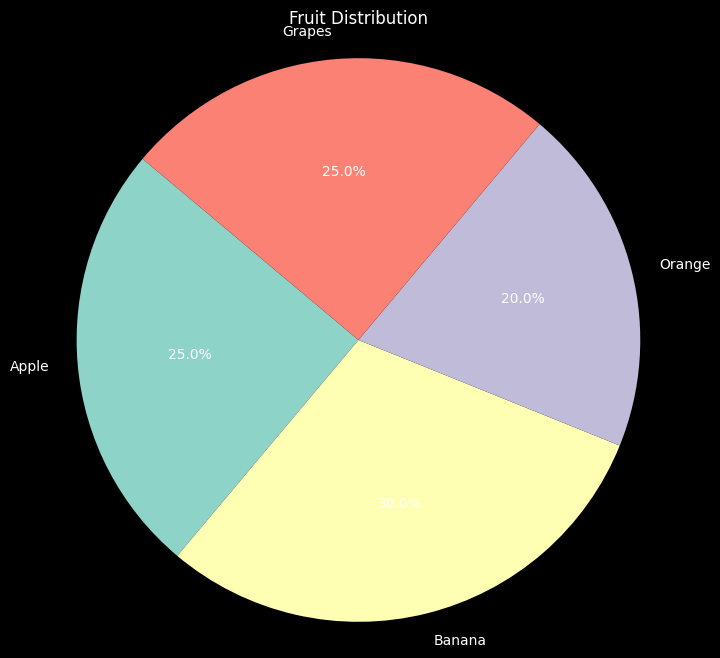

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# Data to plot
labels = ['Apple', 'Banana', 'Orange', 'Grapes']
sizes = [25, 30, 20, 25]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Fruit Distribution')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# Data to plot\nlabels = ['Apple', 'Banana', 'Orange', 'Grapes']\nsizes = [25, 30, 20, 25]\n\n# Plot\nplt.figure(figsize=(8, 8))\nplt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Fruit Distribution')\nplt.show()"}`




Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# Data to plot\nlabels = ['Apple', 'Banana', 'Orange', 'Grapes']\nsizes = [25, 30, 20, 25]\n\n# Plot\nplt.figure(figsize=(8, 8

In [21]:
# 스트리밍 모드로 실행 
result = agent_executor.stream({
    "input":"matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요.",
})

for step in result:
    agent_stream_parser.process_agent_steps(step)

## Callback (Custom)

In [22]:
from langchain_teddynote.messages import AgentCallbacks, AgentStreamParser

In [23]:
# 도구 호출 시 실행되는 콜백 함수
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름 출력
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(f"Observation: {observation.get('observation')[0]}")  # 관찰 내용 출력
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변 출력
    print("<<<<<<< 최종 답변 >>>>>>")

In [24]:
# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수 설정
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

In [25]:
# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱
agent_stream_parser = AgentStreamParser(agent_callbacks)

In [26]:
# 실행 & 출력
result = agent_executor.stream({"input": "AI Agent와 관련된 뉴스를 검색해 주세요."})

for step in result:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>

Invoking: `search_news` with `{'query': 'AI Agent'}`


[{'url': 'https://news.google.com/rss/articles/CBMiugJBVV95cUxNQ2w4LWUwLUJFcnNRUTQ4cUpib1V3aTJtWUs1MnhqOERObjhYTFBab010a25xTFN4Tm41Q05pSlpqSG9QcHpTTVBaUGRkaUduR2NyQzc1bXBROS1IdDBSSkMyRFZnNzQ3TU5ENVVFclRxZTVOWVpRNkFIckcycFQ4b3lYdFZRSnB6dWNrbXB1OUZCQnlTY0R4SWVvS2h0cVl4ejdma0xPZHdkX2MyR3JqVU0zUUhCd05IX0NiQmhrbXQzSzEwcTVmR0hCZms0N3J1VlJoN3lrM0tTcFJWTkdOUGI3Z0ZwSmoxNjRyMXNQRzhKTXZ3RUtNbmpNVzByRHpUUWt4ajd2YWpKVTNXVVhPNHNDdUlETkhPZGhzeGZYWjVoY1JIdGZhSlhiR3JhV3kxQzgtMnFqWFlLZ9IBugJBVV95cUxNQ2w4LWUwLUJFcnNRUTQ4cUpib1V3aTJtWUs1MnhqOERObjhYTFBab010a25xTFN4Tm41Q05pSlpqSG9QcHpTTVBaUGRkaUduR2NyQzc1bXBROS1IdDBSSkMyRFZnNzQ3TU5ENVVFclRxZTVOWVpRNkFIckcycFQ4b3lYdFZRSnB6dWNrbXB1OUZCQnlTY0R4SWVvS2h0cVl4ejdma0xPZHdkX2MyR3JqVU0zUUhCd05IX0NiQmhrbXQzSzEwcTVmR0hCZms0N3J1VlJoN3lrM0tTcFJWTkdOUGI3Z0ZwSmoxNjRyMXNQRzhKTXZ3RUtNbmpNVzByRHpUUWt4ajd2YWpKVTNXVVhPNHNDdUlETkhPZG

# 이전 대화 기억

- 이전의 대화 내용을 기억하기 위해 `RunnableWithMessageHistory`를 사용하여 `AgentExecutor`를 감싸줌 
- [Ref] https://python.langchain.com/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html


In [27]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [28]:
# session_id 를 저장할 딕셔너리 생성
store = {}


# session_id 를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # session_id 가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 채팅 메시지 기록이 추가된 에이전트 생성
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # 대화 session_id
    get_session_history,
    # 프롬프트의 질문이 입력되는 key: "input"
    input_messages_key="input",
    # 프롬프트의 메시지가 입력되는 key: "chat_history"
    history_messages_key="chat_history",
)

In [29]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "안녕? 나는 영희야. 이제 봄이 오는 것 같아."},
    # session_id 설정
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
안녕, 영희! 봄이 오는 소식을 듣고 기쁘네요. 봄에는 따뜻한 날씨와 아름다운 꽃들이 만개하는 모습을 기대할 수 있죠. 봄에 관련된 뉴스나 정보가 궁금하신가요? 함께 찾아볼까요?

> Finished chain.
<<<<<<< 최종 답변 >>>>>>
안녕, 영희! 봄이 오는 소식을 듣고 기쁘네요. 봄에는 따뜻한 날씨와 아름다운 꽃들이 만개하는 모습을 기대할 수 있죠. 봄에 관련된 뉴스나 정보가 궁금하신가요? 함께 찾아볼까요?
<<<<<<< 최종 답변 >>>>>>


In [30]:
response = agent_with_chat_history.stream(
    {"input": "내가 누구인지 알아? 내 이름이 뭐야?"},
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
당연히 알아요, 영희씨! 영희라는 이름을 사용하셨죠. 어떤 도움이 필요하신가요? 함께 무엇을 찾아드릴까요?

> Finished chain.
<<<<<<< 최종 답변 >>>>>>
당연히 알아요, 영희씨! 영희라는 이름을 사용하셨죠. 어떤 도움이 필요하신가요? 함께 무엇을 찾아드릴까요?
<<<<<<< 최종 답변 >>>>>>


In [31]:
response = agent_with_chat_history.stream(
    {
        "input": "나는 SKALA 주식회사에서 AI개발자로 일하고 있어. 내 메일 주소는 younghee@skala.com 이야."
    },
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
SKALA 주식회사에서 AI 개발자로 일하시는 영희씨군요. 멋진 직업이시네요! 이메일 주소도 알려주셔서 감사합니다. 어떤 도움이 필요하신가요, 영희씨? 무엇을 도와드릴까요?

> Finished chain.
<<<<<<< 최종 답변 >>>>>>
SKALA 주식회사에서 AI 개발자로 일하시는 영희씨군요. 멋진 직업이시네요! 이메일 주소도 알려주셔서 감사합니다. 어떤 도움이 필요하신가요, 영희씨? 무엇을 도와드릴까요?
<<<<<<< 최종 답변 >>>>>>


In [32]:
response = agent_with_chat_history.stream(
    {
        "input": "SK주식회사와 관련된 최신 뉴스 3개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `최철수 팀장님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    config={"configurable": {"session_id": "abc123"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>

Invoking: `search_news` with `{'query': 'SK 주식회사'}`


[{'url': 'https://news.google.com/rss/articles/CBMihAFBVV95cUxQOUEtR2cwSkVSS3lJRTRTdWphZGs2N2g3Y253Yms4bEdrNHhadVdlcTRWRDVnVkE2aFo4OVNWZmMzVnM2aUhBNzI4cnNLajFEQklVM3ZWRVpCMkV0RlJDNzRBMjdsWVlqSjFrR3owQmhTWUVJVjUwaWJpMUhPNjU3Z01hSkfSAZgBQVVfeXFMTzVJb0xtcDAxbGZNNVQ4REF0WFl0bThnQTI2aU1vT3Z5akhLU21iTnBPaWFoQ2FGYVVIZmpwVWM0NUM0NnVhM2NZaG90RF9ObDJ6NUQ4OXo0anNsOFNXZFBHNGdVbjNIQm1yVG1xX1VJaGs0N0djei1lTmYtZHd6aFdZNlJyM05zeXIzemJyMl9WUnB1V042a04?oc=5', 'content': '[CSR] “비용 줄여라”… SK 계열사, 그랑서울서 속속 방 뺄 준비 - 조선비즈 - 조선비즈'}, {'url': 'https://news.google.com/rss/articles/CBMiYEFVX3lxTE9OOWxRZDlXSnhYbmlvT0tyVHdfUFZOQ0lDSVJ6blRKdjlUQWJicXM2Nm1vR1I3d2I3Um5KVVE4UHcxdF9Pb1hscWJrbTRuejdmNnBzamhxX1AyMXRDQTVHaNIBeEFVX3lxTFBRcFJ2LWFaTk9NZ3hGcUtmVnc2OS1GSHIyQWExd0RKS0dkWXZaVmtpbnJtcnhobmlMVTc1cUIzdTZjaGYyT3RjNVN1WU9GQU1vYnYxcTBLU3VHdmxQQ0xuOEo1TjhmcTZHYmMwVURSUVNXd2RQb

In [34]:
response = agent_with_chat_history.stream(
    {"input": "작성된 메일 내용을 영어 버전으로 작성해 주세요."},
    # session_id 변경 하면...
    config={"configurable": {"session_id": "def456"}},
)

for step in response:
    agent_stream_parser.process_agent_steps(step)



> Entering new None chain...
Of course! Please provide the content of the email that you would like me to translate into English.

> Finished chain.
<<<<<<< 최종 답변 >>>>>>
Of course! Please provide the content of the email that you would like me to translate into English.
<<<<<<< 최종 답변 >>>>>>


--------
** End of Documents **